<a href="https://colab.research.google.com/github/robinjacobroy/Drosophila_activity_recognition/blob/main/fly_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown 1ie_SKSX7gw0TBEA39bgccIOJb40GoZFI

Downloading...
From: https://drive.google.com/uc?id=1ie_SKSX7gw0TBEA39bgccIOJb40GoZFI
To: /content/fruitfly2.tar.xz
100% 5.02M/5.02M [00:00<00:00, 14.7MB/s]


In [ ]:
#!rm -rf fruitfly_final/no\ courtship
#!mkdir fruitfly
#!tar -xf official.tar.xz -C fruitfly
#!mv fruitfly_final/wing\ song fruitfly_final/wing_song

In [ ]:
#!unzip cutouts.zip
#!mkdir fruitfly_final
#!mv Sorted\ cutouts fruitfly_final
#!mv fruitfly_final/Sorted\ cutouts/* fruitfly_final/

In [ ]:
#!tar -xf fruitfly_final.tar.xz 
!unzip Sorted\ cutouts...zip
!mv Sorted\ cutouts fruitfly_final

In [2]:
import pathlib
data_dir = './fruitfly_final/'
data_dir = pathlib.Path(data_dir)

In [3]:
from collections import Counter
import tensorflow as tf
import numpy as np
import PIL.Image
import math
import PIL
import os

In [4]:
batch_size = 16
img_height = 80
img_width = 80

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1218 files belonging to 6 classes.
Using 853 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1218 files belonging to 6 classes.
Using 365 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Licking', 'Orientation', 'attempt to copulate', 'following', 'no courtship', 'wing song']


###Class_weights

In [ ]:
#@title 
%%timeit
x = []
for image_batch, labels_batch in train_ds:
  x = x+list(labels_batch.numpy())
d1 = dict(Counter(x))
labels_dict = dict(sorted(d1.items()))
print(labels_dict)

labels_dict = {i:0 for i in range(len(class_names))}
for image_batch, labels_batch in train_ds:
    unique = np.unique(labels_batch.numpy(), return_counts=True)
    labels_dict = Counter(labels_dict) + Counter(dict(zip(unique[0], unique[1])))
d1 = dict(labels_dict)
labels_dict = dict(sorted(d1.items()))
print(labels_dict)

In [18]:
l1 = list(train_ds.as_numpy_iterator())
listoflists = [list(l1[i][1]) for i in range(len(l1))]
list_labels = [y for x in listoflists for y in x]
d1 = dict(Counter(list_labels))
labels_dict = dict(sorted(d1.items()))
print(labels_dict)
sum(labels_dict.values())

{0: 15, 1: 203, 2: 10, 3: 374, 4: 87, 5: 164}


853

In [19]:
def get_class_weight(labels_dict):
    """Calculate the weights of different categories
    """
    total = sum(labels_dict.values())
    max_num = max(labels_dict.values())
    class_weight = dict()
    for key, value in labels_dict.items():
        score = math.log(max_num/ float(value))
        class_weight[key] = score if score > 1.0 else 1.0
    return class_weight

class_weights = get_class_weight(labels_dict)
print(class_weights)

{0: 3.2162055963123217, 1: 1.0, 2: 3.6216707044204863, 3: 1.0, 4: 1.458347678759948, 5: 1.0}


###rest of the training

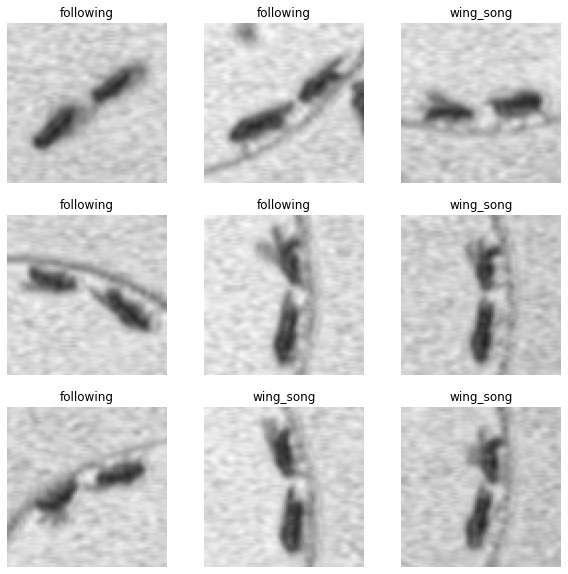

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=123),
  tf.keras.layers.RandomRotation(0.25, seed=123),
])

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
]);

In [ ]:
#@title 
##NEW 
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),  
  tf.keras.layers.Conv2D(16, 3, padding='same',kernel_initializer='he_uniform', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(32, 3, padding='same',kernel_initializer='he_uniform', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
es = [
        tf.keras.callbacks.EarlyStopping(            
        # Stop training when `val_loss` is no longer improving
        monitor="val_accuracy",
        # "no longer improving" being defined as "no better than 1e-2 less"
        mode = 'max',
        # "no longer improving" being further defined as "for at least 5 epochs"
        patience=5,
        verbose=1,
    )
]
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(train_ds, validation_data=val_ds, \
                    epochs=200, verbose=1, callbacks=[mc])#, class_weight=class_weights )

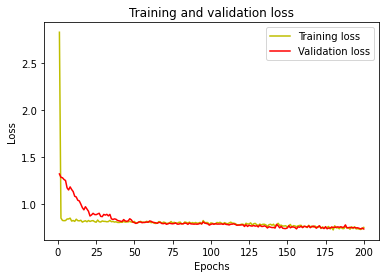

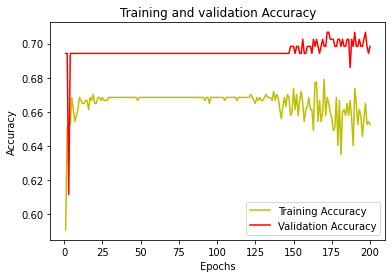

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
del model 
model = tf.keras.models.load_model('best_model.h5')
score = model.evaluate(val_ds, verbose=0)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

Validation loss: 0.3962409794330597
Validation accuracy: 0.8693181872367859


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving done_images.csv to done_images.csv


In [ ]:
!unzip Cutouts.zip
!mkdir -p testB/sub
!mv -f Cutouts/*.png testB/sub/

###evaluate model performance on an set of images

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  pathlib.Path('./testB'),
  labels=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2187 files belonging to 1 classes.


In [ ]:
predictions = model.predict(test_ds)
# Generate arg maxes for predictions
classes = np.argmax(predictions, axis = 1)
print(classes)

[0 3 0 ... 3 0 3]


###evaluate model performance on individual images




In [ ]:
def test_im(fln):
  test = tf.keras.utils.load_img(fln)
  input_arr = tf.keras.preprocessing.image.img_to_array(test)
  input_arr = np.array([input_arr])  # Convert single image to a batch.
  predictions = model(input_arr, training=False)
  classes = np.argmax(predictions, axis = -1)
  print(class_names[classes[0]])
  print(predictions[0])

In [ ]:
print(class_names)
test_im('Crpp_15264_1.png')
test_im('Crpp_14765_0.png')
test_im('Crpp_7450_1.png')
test_im('Pos_A_453_2268.png')

['attempt_copulate', 'following', 'licking', 'wing_song']
wing_song
[-3.8023481 -1.0806161 -1.1484116  4.0488405]
following
[-2.2057877   1.0999266  -0.9255064   0.85623485]
wing_song
[-3.8591454 -1.014462  -1.2296087  4.0512776]
following
[-3.1278133  2.3609538 -2.1060212  1.5533717]


In [ ]:
model.save("noisy_fly.h5")

In [ ]:
import tensorflow as tf
import numpy as np
fln = './fruitfly_final/attempt_copulate/Pos_A_106_531.png'
img = tf.keras.utils.load_img(fln)

In [ ]:
inp = tf.keras.preprocessing.image.img_to_array(img)
res_im = tf.image.resize(inp, [80,80], method='bilinear')

In [ ]:
np.array_equal(np.array(img),res_im.numpy().astype('uint8'))

True